In [ ]:
# 총 몇장을 보는걸까?
# 2000장을 train_generator가 만들어내고,
# epoch마다 계속 새로운 2000장을 생성
# 2000장 epoch 100이라면 20만장을 보는 것과 같다

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import matplotlib.pyplot as plt

In [3]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras import models
from keras.models import load_model
from keras import backend as K

In [4]:
import tensorflow as tf

In [5]:
keras.__version__ , tf.__version__

('2.4.3', '2.4.1')

In [6]:
tf.test.gpu_device_name()

!nvidia-smi

Tue Mar 23 05:38:46 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P0    31W /  70W |    222MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [7]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
!ls -l '/content/drive/My Drive/Colab Notebooks/datasets/'

total 1741130
-rw------- 1 root root      20066 Mar  4 04:45 cat.1700.jpg
-rw------- 1 root root   68787205 Mar  9 04:06 creditCardFraud.zip
-rw------- 1 root root   90618980 Mar  4 04:51 dogs_and_cats_small.zip
drwx------ 2 root root       4096 Mar  9 04:27 image
-rw------- 1 root root    8204887 Mar  4 04:45 Images_500.zip
-rw------- 1 root root    4240457 Mar 15 04:25 Kaggle_Customer_Satisfaction.zip
-rw------- 1 root root   12929865 Mar  4 04:42 Logo_Data.zip
-rw------- 1 root root   18272469 Mar  4 04:50 MNIST.csv
-rw------- 1 root root   23715344 Mar  7 07:08 Online_Retail.xlsx
-rw------- 1 root root        741 Mar  4 04:44 PII.csv
-rw------- 1 root root 1141460846 Mar  4 04:50 waferImages.zip
-rw------- 1 root root  414658234 Mar  4 04:49 yolo_weight.zip


In [10]:
! unzip /content/drive/My\ Drive/Colab\ Notebooks/datasets/dogs_and_cats_small.zip

Archive:  /content/drive/My Drive/Colab Notebooks/datasets/dogs_and_cats_small.zip
  inflating: test/cats/cat.1501.jpg  
  inflating: test/cats/cat.1502.jpg  
  inflating: test/cats/cat.1503.jpg  
  inflating: test/cats/cat.1504.jpg  
  inflating: test/cats/cat.1505.jpg  
  inflating: test/cats/cat.1506.jpg  
  inflating: test/cats/cat.1507.jpg  
  inflating: test/cats/cat.1508.jpg  
  inflating: test/cats/cat.1509.jpg  
  inflating: test/cats/cat.1510.jpg  
  inflating: test/cats/cat.1511.jpg  
  inflating: test/cats/cat.1512.jpg  
  inflating: test/cats/cat.1513.jpg  
  inflating: test/cats/cat.1514.jpg  
  inflating: test/cats/cat.1515.jpg  
  inflating: test/cats/cat.1516.jpg  
  inflating: test/cats/cat.1517.jpg  
  inflating: test/cats/cat.1518.jpg  
  inflating: test/cats/cat.1519.jpg  
  inflating: test/cats/cat.1520.jpg  
  inflating: test/cats/cat.1521.jpg  
  inflating: test/cats/cat.1522.jpg  
  inflating: test/cats/cat.1523.jpg  
  inflating: test/cats/cat.1524.jpg  
  inf

## 2. Data Preprocessing

### 1) Image File Directory Setting

In [11]:
train_dir = 'train'
valid_dir = 'validation'
test_dir = 'test'

### 2) ImageDataGenerator() & flow_from_directory()

- rotation_range = 40: 0도에서 40도 사이에서 임의의 각도로 회전
- width_shift_range = 0.2 : 20% 픽셀 내외로 좌우 이동
- height_shift_range = 0.2 : 20% 픽셀 내외로 상하 이동
- shear_range = 0.2 : 0.2 라디안 내외로 시계 반대방향으로 변형
- zoom_range = 0.2 : 80%에서 120% 범위에서 확대/축소
- horizontal_flip = True : 수평방향 뒤집기
- vertical_flip = True : 수직방향 뒤집기
- fill_mode = 'nearest' : 주변픽셀로 이미지 채우기

In [13]:
# With Augmentation
train_generator = ImageDataGenerator(rescale = 1. / 255 ,
                                     rotation_range = 40,
                                     width_shift_range = 0.2 ,
                                     height_shift_range = 0.2 ,
                                     shear_range = 0.2 ,
                                     zoom_range = 0.2 ,
                                     horizontal_flip = True ,
                                     vertical_flip = True ,
                                     fill_mode = 'nearest')

train_set = train_generator.flow_from_directory(
    train_dir,
    target_size = (150, 150),
    batch_size = 20,
    class_mode = 'binary'
)


# Witout Augmentation
valid_generator = ImageDataGenerator(rescale = 1. / 255)

valid_set = valid_generator.flow_from_directory(
    valid_dir,
    target_size = (150, 150),
    batch_size = 20,
    class_mode = 'binary'
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


## 3. CNN Keras Modeling

### 1) Model Define
- Feature Extraction & Classification
  - Dropout Layer

In [23]:
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation = 'relu',
                        input_shape = (150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation = 'relu'))
model.add(layers.Dense(1, activation = 'sigmoid'))

In [24]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 15, 15, 128)      

## 2) Model Compile

In [25]:
model.compile(loss = 'binary_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])

### 3) Model Fit
- epoch 100: 약 30분

In [26]:
%%time

Hist_dandc = model.fit(train_set,
                       steps_per_epoch = 100,
                       epochs = 200,
                       validation_data = valid_set,
                       validation_steps = 50)

Epoch 1/200
100/100 [==============================] - 18s 178ms/step - loss: 0.6966 - accuracy: 0.5162 - val_loss: 0.6939 - val_accuracy: 0.5010
Epoch 2/200
100/100 [==============================] - 18s 176ms/step - loss: 0.6934 - accuracy: 0.5194 - val_loss: 0.6937 - val_accuracy: 0.5000
Epoch 3/200
100/100 [==============================] - 17s 174ms/step - loss: 0.6933 - accuracy: 0.5049 - val_loss: 0.6917 - val_accuracy: 0.6020
Epoch 4/200
100/100 [==============================] - 17s 174ms/step - loss: 0.6929 - accuracy: 0.5177 - val_loss: 0.6879 - val_accuracy: 0.5560
Epoch 5/200
100/100 [==============================] - 18s 176ms/step - loss: 0.6913 - accuracy: 0.5374 - val_loss: 0.6802 - val_accuracy: 0.5900
Epoch 6/200
100/100 [==============================] - 18s 176ms/step - loss: 0.6784 - accuracy: 0.5750 - val_loss: 0.6904 - val_accuracy: 0.5360
Epoch 7/200
100/100 [==============================] - 17s 175ms/step - loss: 0.6899 - accuracy: 0.5074 - val_loss: 0.6782 -

### 4) 학습결과 시각화
- Loss Visualization

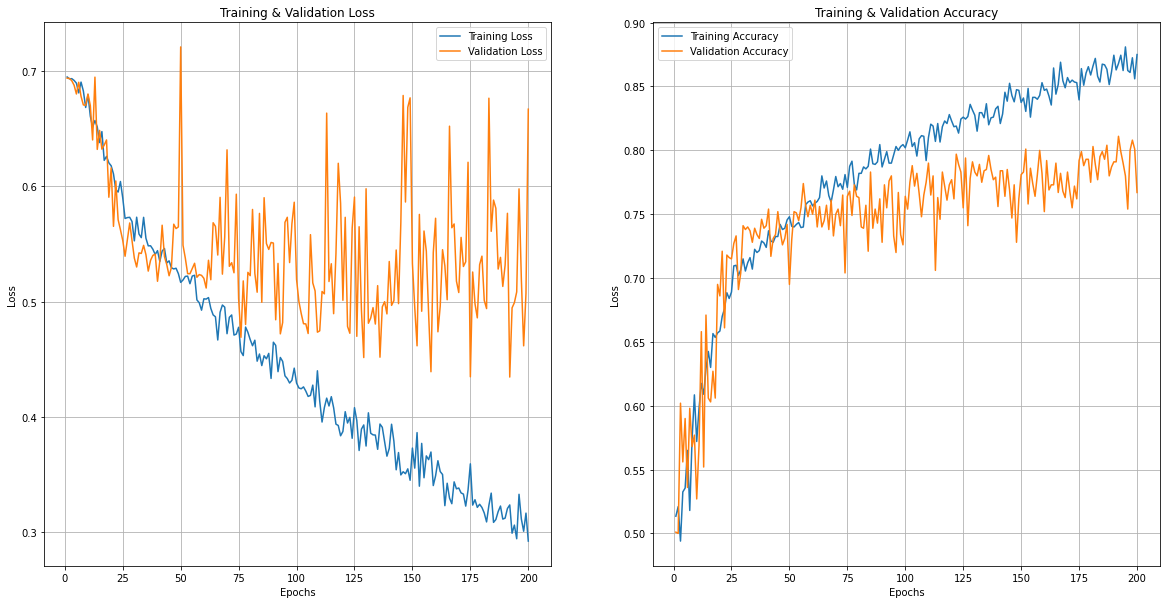

In [27]:
epochs = range(1, len(Hist_dandc.history['loss']) + 1)

plt.figure(figsize = (20, 10))

plt.subplot(1, 2, 1)
plt.plot(epochs, Hist_dandc.history['loss'])
plt.plot(epochs, Hist_dandc.history['val_loss'])


plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training Loss' , 'Validation Loss'])
plt.grid()


plt.subplot(1, 2, 2)
plt.plot(epochs, Hist_dandc.history['accuracy'])
plt.plot(epochs, Hist_dandc.history['val_accuracy'])


plt.title('Training & Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training Accuracy' , 'Validation Accuracy'])
plt.grid()

plt.show()

### 5) Model Evaluate
- test_generator

In [28]:
test_generator = ImageDataGenerator(rescale = 1. / 255)

test_set = test_generator.flow_from_directory(
    test_dir,
    target_size = (150, 150),
    batch_size = 20,
    class_mode = 'binary'
)

Found 1000 images belonging to 2 classes.


In [29]:
loss, accuracy = model.evaluate(test_set, steps = 50)

print('Loss: {:.5f}' .format(loss))
print('Accuracy: {:.5f}' .format(accuracy))

50/50 [==============================] - 3s 55ms/step - loss: 0.6915 - accuracy: 0.7630
Loss: 0.69152
Accuracy: 0.76300


## Model Save & Load to Google Drive

### 1) Google Drive Mount

In [ ]:
drive.mount('/content/drive')

### 2) Model Save

In [30]:
model.save('/content/drive/My Drive/Colab Notebooks/models/003_dogs_and_cats_augmentation.h5')

In [31]:
!ls -l /content/drive/My\ Drive/Colab\ Notebooks/models

total 120035
-rw------- 1 root root    34592 Mar 18 02:42 001_Model_iris.h5
-rw------- 1 root root 41498896 Mar 23 02:18 002_dogs_and_cats_small.h5
-rw------- 1 root root 41501624 Mar 23 07:12 003_dogs_and_cats_augmentation.h5
-rw------- 1 root root 39879700 Mar 23 06:41 004_logo_classification_with_augmentation.h5


### 3) Model Load

In [33]:
model_google = load_model('/content/drive/My Drive/Colab Notebooks/models/003_dogs_and_cats_augmentation.h5')

In [34]:
loss, accuracy = model.evaluate(test_set, steps = 50)

print('Loss: {:.5f}' .format(loss))
print('Accuracy: {:.5f}' .format(accuracy))

50/50 [==============================] - 3s 55ms/step - loss: 0.6915 - accuracy: 0.7630
Loss: 0.69152
Accuracy: 0.76300
